# Procesamiento de archivos .sig

Este notebook contiene código y documentación relacionada con el procesamiento y guardado de firmas espectrales en formato .sig que obtiene el espectrorradiómetro SVC HR-1024i.

Fecha: 16 de julio de 2023

mail: taveiragerman@gmail.com

---

En este notebook, se realiza el análisis de firmas utilizando datos de campo y se generan visualizaciones y exportaciones de los resultados. El código y la documentación se presentan en celdas separadas para facilitar la comprensión y el seguimiento del proceso.

A continuación, se importarán las bibliotecas necesarias y se definirán las variables y funciones iniciales requeridas para el análisis. Luego, se procederá con la carga de datos y el procesamiento de las firmas.

## 0. Cargar paquetes requeridos

En esta celda se cargan los paquetes necesarios para el análisis de datos y la generación de gráficos.

Asegúrate de tener instalados los siguientes paquetes antes de ejecutar el código:

- `pandas`: Se importa la biblioteca `pandas` para el análisis de datos. Esta biblioteca proporciona estructuras de datos y herramientas para el manejo y análisis de datos tabulares.
- `numpy`: Se importa la biblioteca `numpy` para trabajar con matrices y vectores. `numpy` proporciona funciones y métodos para realizar operaciones numéricas eficientes en matrices y vectores.
- `matplotlib.pyplot`: Se importa el módulo `pyplot` de la biblioteca `matplotlib` para graficar datos. `pyplot` proporciona funciones para crear y personalizar gráficos.
- `os`: Se importa el módulo `os` para interactuar con el sistema operativo. Este módulo permite realizar operaciones relacionadas con archivos y directorios, como leer, escribir y manipular rutas de archivos.
- `datetime` y `timedelta`: Se importan las clases `datetime` y `timedelta` del módulo `datetime` para trabajar con fechas y tiempos. Estas clases proporcionan funcionalidades para manejar y calcular fechas y tiempos.
- `geopandas`: Se importa la biblioteca `geopandas` para trabajar con datos geoespaciales. `geopandas` combina las capacidades de `pandas` y `geopandas` para proporcionar una forma conveniente de trabajar con datos espaciales en Python.

Además, se requiere el módulo `xlsxwriter` para guardar las firmas en formato XLSX. Si no lo tienes instalado, puedes instalarlo utilizando el siguiente comando:

```
pip install xlsxwriter
```

Asegúrate de tener instalados todos los paquetes necesarios para que el código se ejecute correctamente.

In [1]:
import pandas as pd  # Importa la biblioteca pandas para abrir csv con datos de campo
from functions import * # Importa las funciones del archivo functions.py. El archivo debe estar en la misma carpeta que la notebook

## 1. Configuración de rutas

En esta celda se configuran los parámetros asociados a las rutas donde se encuentran los archivos y carpetas necesarios para el procesamiento.

El código utiliza las siguientes variables:

- `cobertura`: indica la cobertura de la serie de datos. Puedes asignar un valor descriptivo, como 'cebada', por ejemplo.
- `hours_offset`: establece la diferencia de tiempo entre la zona horaria de la señal SIG y la zona horaria local. Ajusta este valor según la diferencia horaria correspondiente.

- `path_out`: especifica la carpeta de salida para el procesamiento. Aquí se guardarán los archivos resultantes.
- `path_sig`: indica la ruta donde se encuentran las carpetas que contienen los archivos .sig. Asegúrate de proporcionar la ruta correcta donde se encuentran los archivos .sig correspondientes a la cobertura especificada.
- `path_tabla_zonas`: es la ruta del archivo CSV que contiene los datos ambientales recogidos en campo, como temperatura, humedad, LAI, etc. Asegúrate de proporcionar la ruta correcta donde se encuentra este archivo.
- `path_tabla_amb`: es la ruta del archivo CSV que contiene la fecha, número de firma, zona, nombre de la zona y distancia de cada dato. Asegúrate de proporcionar la ruta correcta donde se encuentra este archivo.

Antes de ejecutar el código, asegúrate de ajustar estas variables según tus necesidades y la ubicación de los archivos en tu sistema. Esto asegurará que el procesamiento se realice correctamente y los resultados se guarden en las ubicaciones deseadas.


In [2]:
cobertura = 'cebada'  # Cobertura de la serie
hours_offset = -19  # Se define la diferencia de tiempo entre la zona horaria de la señal SIG y la zona horaria local

path_out = './output/'  # Carpeta de salida del procesamiento
path_sig = './input/sig/'  # Ruta donde se ubican las carpetas con los .sig
path_tabla_zonas = './input/tablas/tabla_campo_2022_zonas.csv'  # Tabla con datos ambientales recogidos en campo (T,HS,LAI,etc)
path_tabla_amb = './input/tablas/tabla_campo_2022_amb.csv'  # Tabla con fecha, n_firma, zona, nombre_zona y distancia de cada dato

## 2. Abrir csv con datos de zonas y distancias

En este código, se abre un archivo CSV llamado `tabla_campo` que contiene los datos de zonas y distancias. A continuación, se realiza el siguiente procesamiento:

1. Se lee el archivo CSV utilizando la función `pd.read_csv()` de la biblioteca pandas y se carga en un DataFrame llamado `tabla_campo`.

2. Se crea una nueva columna llamada 'id_date' en el DataFrame `tabla_campo`. Esta columna se crea a partir de la columna existente 'fecha'.

3. Primero, se convierte la columna 'fecha' a un objeto datetime utilizando el formato 'dd/mm/yyyy'. Esto se logra utilizando la función `pd.to_datetime()` y especificando el formato de fecha adecuado, en este caso, '%d/%m/%Y'.

4. A continuación, se convierte el objeto datetime a una cadena con el formato 'yyyymmdd' utilizando el método `dt.strftime('%Y%m%d')`. El resultado se guarda en la columna 'id_date'.

El DataFrame `tabla_campo` ahora contiene una nueva columna 'id_date' que contiene las fechas en el formato 'yyyymmdd'. Esto facilita el procesamiento y la agrupación de los datos por fecha en etapas posteriores del código.

In [3]:
# Carga un archivo CSV en un DataFrame usando pandas
tabla_campo = pd.read_csv(path_tabla_zonas)  
tabla_campo['id_date'] = pd.to_datetime(tabla_campo['fecha'], format='%d/%m/%Y').dt.strftime('%Y%m%d')

tabla_campo.head(3)

,fecha,n_firma,zona,nombre_zona,distancia,id_date
0,19/8/2022,1,1,bajo,1,20220819
1,19/8/2022,2,1,bajo,1,20220819
2,19/8/2022,3,1,bajo,1,20220819


## 3. Lectura de .sig
En este código, se crea una lista de diccionarios llamada `firmas`, donde cada diccionario contiene una firma y sus metadatos. La función `open_sig()` se utiliza para abrir y leer los archivos .sig en la ubicación especificada por `path_sig`, y la función `list_sig()` genera una lista de nombres de archivos .sig en el directorio. Además, se pasa el parámetro `hours_offset` para ajustar la diferencia de tiempo entre la zona horaria de la señal SIG y la zona horaria local.

Después, puedes acceder al dataframe de la primera firma en la lista utilizando la clave `'data'` del primer diccionario: `firmas[0]['data']`. El resultado muestra una parte del dataframe, con las columnas `'radiancia_original'`, `'target_original'`, `'reflectancia'`, `'radiancia'`, y `'target'`. Los valores de `'radiancia_original'`, `'target_original'` y `'reflectancia'` son copiados directamente del archivo .sig, mientras que los valores de `'radiancia'` y `'target'` son los mismos pero escalados.

Recuerda que puedes cambiar el índice `0` en `firmas[0]` para acceder a los dataframes de otras firmas en la lista.

In [4]:
# Se obtiene una lista de diccionarios, cada uno con las firmas y sus metadatos
firmas = open_sig(sig_list= list_sig(path=path_sig), hours_offset=hours_offset)

# Se visualiza parte del df
firmas[0]['data'].head(3)

,longitud_onda,radiancia_original,target_original,radiancia,target,reflectancia
0,338.5,92373.63,825.58,92.37363,0.82558,0.89
1,340.0,98152.44,851.50,98.15244,0.85150,0.87
2,341.5,99091.96,852.48,99.09196,0.85248,0.86


## 4. Procesamiento y metadatos

La función `procesar_firmas_ind()` toma como entrada las firmas, la diferencia horaria (`hours_offset`), la cobertura y la tabla de datos de zonas tomadas en campo (`tabla_campo`). 

En primer lugar, utiliza la función `agrupar_firmas()` para agrupar las firmas por día. Esta función devuelve un diccionario donde cada clave es la fecha del día y las firmas se agrupan en listas dentro de cada fecha.

A continuación, se llama a la función `agregar_metadatos()` para agregar los metadatos a cada firma en base a la tabla de datos de zonas tomadas en campo. Esta función agrega información como zona, nombre_zona, distancia, cobertura, id_firma, entre otros. Además, realiza la conversión de las coordenadas GMS a grados decimales y las almacena en nuevas claves llamadas `'coordenadas_target'` y `'coordenadas_radiancia'`, utilizando los metadatos existentes.

Por último, se devuelve el diccionario `dic_firmas_por_fecha` que contiene las firmas agrupadas por fecha y con los metadatos agregados.

> **Nota Importante**
> Para que se puedan leer correctamente los datos de la tabla `tabla_campo`, deben seguir el formato indicado en la imagen a continuación:
> ![Ejemplo de formato de la tabla tabla_campo](attach/image_tabla_zona.png)


In [5]:
# Las firmas se agrupan por día en un diccionario
# Cada key del diccionario es la fecha del día en el que se tomaron las firmas
# Las firmas dentro de cada fecha se agrupan en lista
# A cada firma se le agregan metadatos en base a la tabla de datos de zonas tomadas en campo

dic_firmas_por_fecha = procesar_firmas_ind(firmas, hours_offset, cobertura, tabla_campo)


## 5. Ploteo de 'data' por día

En este código, se utiliza la función `plot_firmas()` para visualizar las firmas por día. Se especifica la zona (`num_zona`) y la distancia (`distancia`) que deseas plotear.

Asegúrate de que la variable `dic_firmas_por_fecha` contenga el diccionario con las firmas agrupadas por fecha y con los metadatos agregados, como se obtiene en la función `procesar_firmas_ind()`.

La función `plot_firmas()` se encarga de trazar los gráficos de reflectancias para cada día, correspondiente a la zona y distancia seleccionadas. Los gráficos mostrarán las firmas espectrales para los valores de reflectancia en función de la longitud de onda.

Antes de ejecutar este código, asegúrate de tener los datos adecuados en `dic_firmas_por_fecha` y haber ejecutado la función `procesar_firmas_ind()` previamente para obtener el diccionario con las firmas agrupadas y los metadatos agregados.

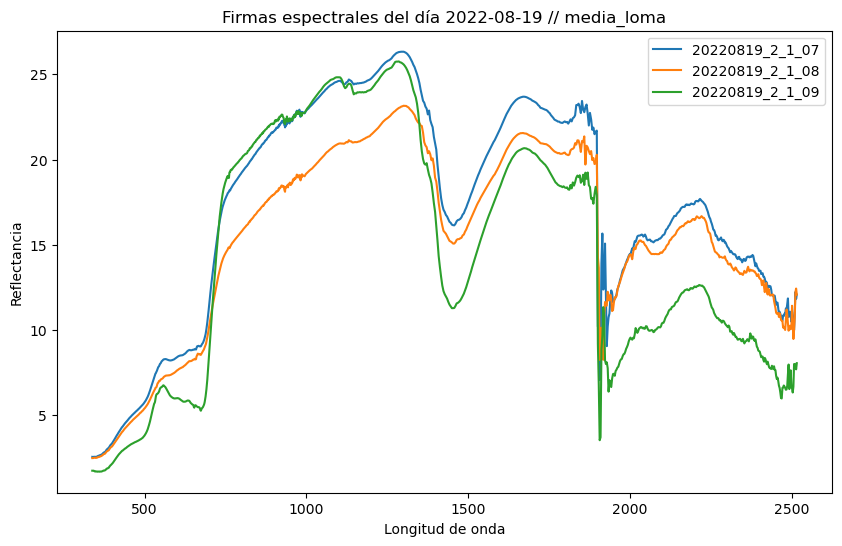

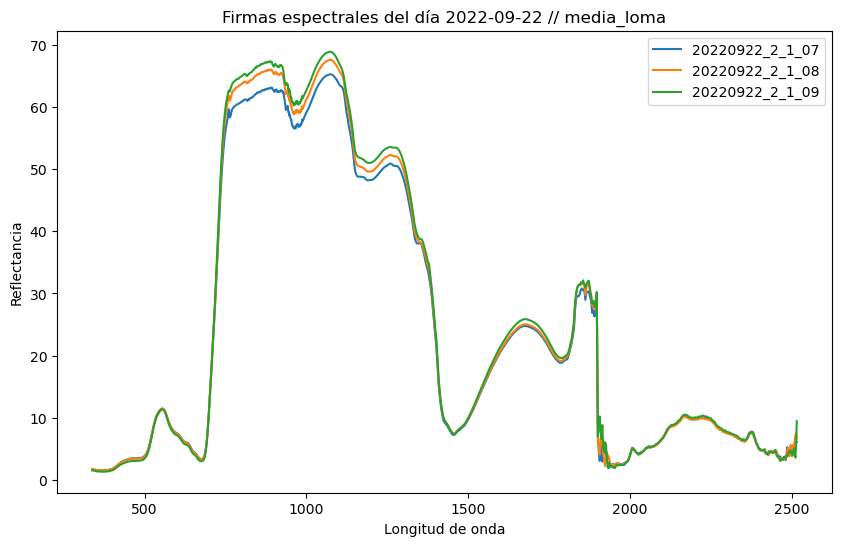

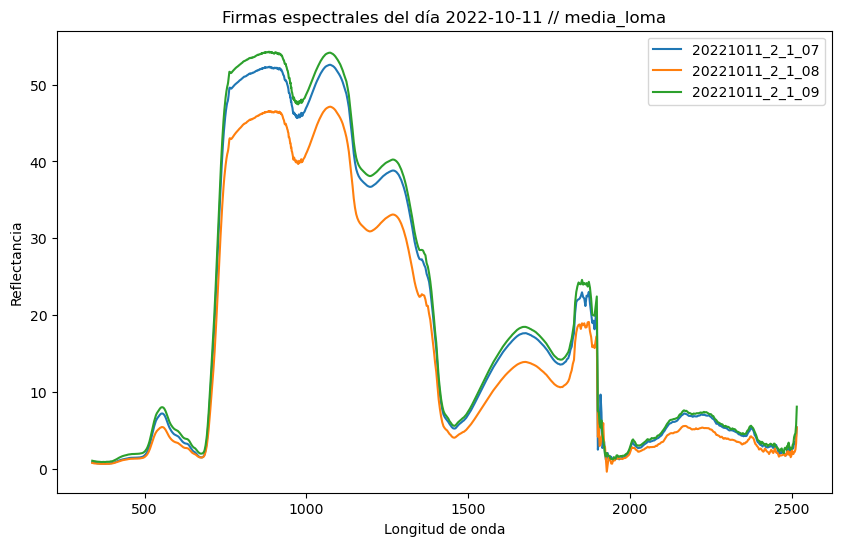

In [6]:
### Se plotea 'data' por día 
## Reflectancias, radiancias y target por del DIA ##

# Seteo las firmas que quiero plotear
num_zona = 2
distancia = 1

plot_firmas_individuales(dic_firmas_por_fecha,
            num_zona,
            distancia)


## 6. Guardar en xlsx las firmas individuales

En este código, se utiliza la función `export_xlsx()` para guardar todas las firmas individuales en un único archivo XLSX. Se especifica la ruta de salida (`path_out`), el diccionario de firmas agrupadas por fecha (`dic_firmas_por_fecha`) y la cobertura (`cobertura`).

La función `export_xlsx()` se encarga de crear un archivo XLSX y guardar cada firma en una hoja nueva dentro del archivo. Cada hoja del archivo contendrá los datos de una firma individual.

Asegúrate de tener la biblioteca `xlsxwriter` instalada para que la exportación a Excel se realice correctamente. Puedes instalarla utilizando el siguiente comando:

```
pip install xlsxwriter
```

Antes de ejecutar este código, asegúrate de tener los datos adecuados en `dic_firmas_por_fecha` y proporciona una ruta válida en `path_out` para la ubicación y el nombre del archivo XLSX de salida.

In [7]:
# Guardar en xlsx
export_xlsx(path_out= path_out,
            dic_firmas= dic_firmas_por_fecha,
            cobertura= cobertura)

## 7. Promedio de medidas por zona y vínculo con datos ambientales de campo

En esta función, se pasa como entrada el diccionario `dic_firmas_por_fecha` que contiene las firmas individuales agrupadas por fecha. Además, se proporciona la ruta del archivo de datos ambientales de campo (`path_tabla_amb`).

La función `promediar_firmas_amb()` realiza los siguientes pasos:

1. Utiliza la función `promediar_firmas()` para calcular el promedio de las firmas por zona. Esto resulta en un nuevo diccionario llamado `firmas_prom`, que contiene las firmas promediadas por zona.

2. Utiliza la función `vincular_amb_data()` para vincular los datos ambientales de campo a las firmas promediadas. Estos datos ambientales, que se encuentran en el archivo especificado por `path_tabla_amb`, se agregan como metadatos a las firmas promediadas.

3. Finalmente, se utiliza la función `agrupar_firmas_prom()` para agrupar las firmas promediadas por fecha en un nuevo diccionario llamado `dic_firmas_por_fecha_prom`.

La función devuelve `dic_firmas_por_fecha_prom`, que es el diccionario de firmas promediadas por fecha y vinculadas con los datos ambientales de campo.

Asegúrate de tener las funciones `promediar_firmas()`, `vincular_amb_data()` y `agrupar_firmas_prom()` definidas y disponibles antes de utilizar esta función. Además, asegúrate de tener los datos adecuados en `dic_firmas_por_fecha` y el archivo de datos ambientales de campo en la ruta especificada por `path_tabla_amb`.


> [i] Importante!!
> Para que se puedan leer correctamente los datos 'tabla_amb' deben seguir el formato: <br>
> ![Alt text](attach/image_tabla_amb.png) <br>
> Aquí las variables pueden cambiar, lo que se debe mantener es que los nombres de los campos estén en la segunda fila y se mantenga el nombre y formato de fecha.

In [8]:
# Promedio de medidas por zona y vínculo con datos ambientales de campo
dic_firmas_por_fecha_prom = promediar_firmas_amb(dic_firmas_por_fecha, path_tabla_amb)

## 8. Ploteo de 'data' promedio por día

En este código, se configuran las variables `num_zona`, `distancia`, `plot` y `x_lim` para especificar los parámetros deseados para el ploteo.

- `num_zona` define la zona que quieres plotear.
- `distancia` especifica la distancia que quieres considerar.
- `plot` indica qué tipo de datos quieres visualizar. Puedes elegir entre 'rad' para las radiancias, 'ref' para las reflectancias o dejarlo por defecto ('rad') para las radiancias.
- `x_lim` establece los límites del eje X para el gráfico. Puedes ajustar los valores numéricos para personalizar los límites.

Luego, se llama a la función `plot_firmas()` con los parámetros establecidos para trazar las firmas promediadas por fecha según las especificaciones dadas.

Asegúrate de tener la función `plot_firmas()` definida y disponible antes de utilizar este código. Además, asegúrate de tener los datos adecuados y haber ejecutado la función `promediar_firmas_amb()` previamente para obtener las firmas promediadas por fecha.

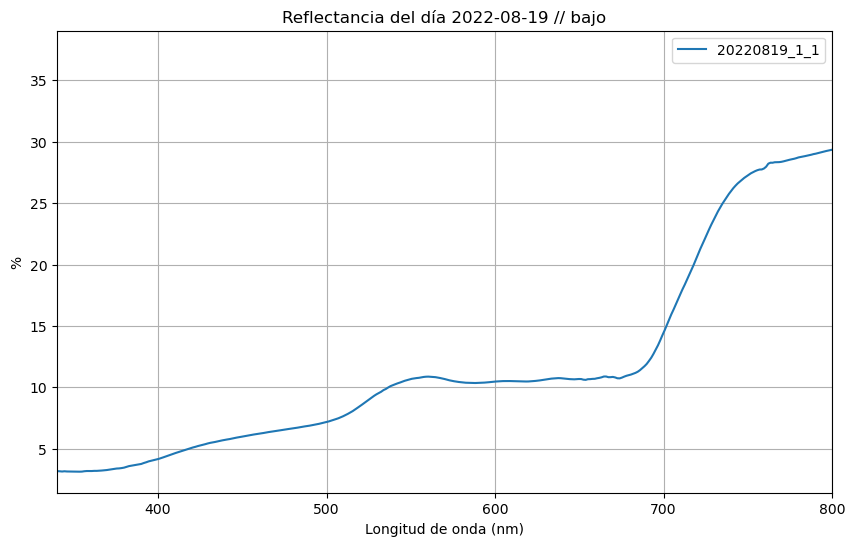

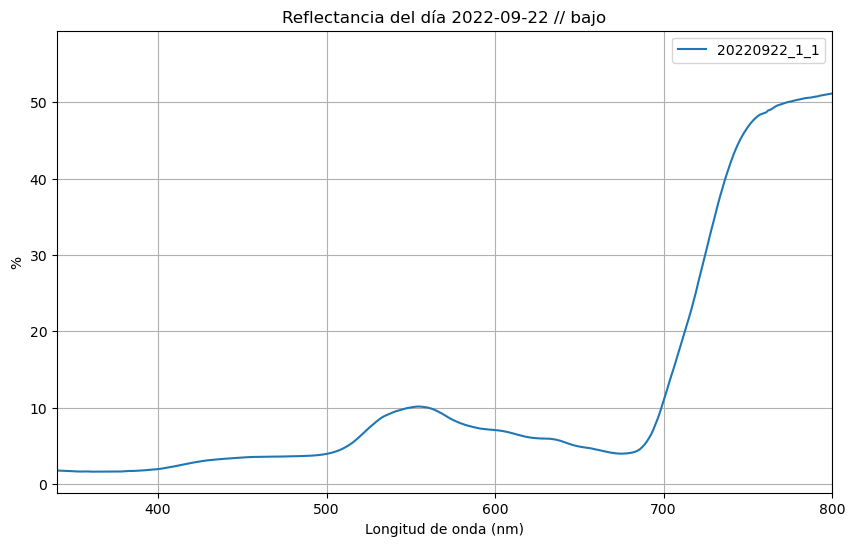

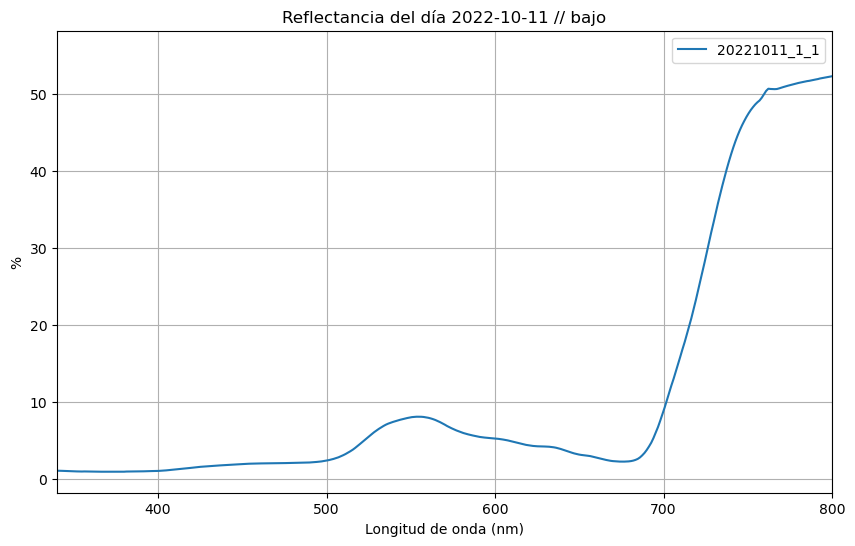

In [9]:
# Seteo las firmas que quiero plotear
num_zona = 1
distancia = 1
plot = 'ref' # rad = radiancias, ref = reflectancias, defoult = radiancias
x_lim = (340,800)

plot_firmas(firmas_fecha= dic_firmas_por_fecha_prom, zona= num_zona, distancia= distancia, plot= plot, x_lim = x_lim)

# #########################

## 9. Guardar en xlsx las firmas individuales

En este código, se utiliza la función `export_xlsx()` para guardar las firmas promediadas por día en un archivo XLSX. Se especifica la ruta de salida (`path_out`), el diccionario de firmas promediadas por fecha (`dic_firmas_por_fecha_prom`), la cobertura (`cobertura`) y se establece el parámetro `prom` en `True` para indicar que son firmas promediadas.

La función `export_xlsx()` se encarga de crear un archivo XLSX y guardar cada firma promediada en una hoja nueva dentro del archivo. Cada hoja del archivo contendrá los datos de una firma promediada.

Asegúrate de tener la biblioteca `xlsxwriter` instalada para que la exportación a Excel se realice correctamente. Puedes instalarla utilizando el siguiente comando:

```
pip install xlsxwriter
```

Antes de ejecutar este código, asegúrate de tener los datos adecuados en `dic_firmas_por_fecha_prom` y haber ejecutado la función `promediar_firmas_amb()` previamente para obtener las firmas promediadas por fecha. Además, asegúrate de proporcionar una ruta válida en `path_out` para la ubicación y el nombre del archivo XLSX de salida.


In [10]:
# Guardar firmas promediadas en xlsx
export_xlsx(path_out= path_out,
            dic_firmas= dic_firmas_por_fecha_prom,
            cobertura= cobertura,
            prom = True)